# Sentiment Analysis

### NLP workflow

<img src="resources/pipeline.png">

In [1]:
import os
import re
import string
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from tqdm.auto import tqdm
from nltk.util import ngrams
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# for BERT
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

pd.set_option("max_colwidth", 500) # Set display column width to show more content

In [2]:
# If this is the first time you use nltk, make sure to download necessary resources and pre-trained models

# nltk.download()

## Get familiar with dataset

In [3]:
df = pd.read_csv('./IMDB-Dataset.csv')

df

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is calle...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ru...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is conne...",positive
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lotta fun. the more i think about it the more i like it, and when it comes out on DVD I'm going to pay the money for it very proudly, every last cent. Sharon Stone is great, she always is, even if her movie is horrible(Catwoman), but this movie isn't, this is one of those movies that will be underrated for its lifetime, and it will probably become a c...",positive
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a crappy copy of the VHS cannot be redeemed by consuming liquor. Trust me, because I stuck this turkey out to the end. It was so pathetically bad all over that I had to figure it was a fourth-rate spoof of Springtime for Hitler.<br /><br />The girl who played Janis Joplin was the only faint spark of interest, and that was only because she could sing b...",negative
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high school & college. I am still a practicing Catholic but would not be considered a ""good Catholic"" in the church's eyes because I don't believe certain things or act certain ways just because the church tells me to.<br /><br />So back to the movie...its bad becau

In [4]:
df.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

**Data is balanced**

## Preprocessing

### EDA

In [5]:
stopwords = set(nltk.corpus.stopwords.words('english'))
print(len(stopwords))
print(stopwords)

179
{'he', "hasn't", 'ourselves', 'doesn', 'have', 'until', 'for', 'between', "it's", 'again', 'above', "shouldn't", "haven't", 'i', "she's", "aren't", 'just', 'our', 'very', 'don', 'are', 'out', 'nor', 'd', 'she', 'be', 'were', 'than', 'they', 'same', 'under', 'hadn', 'wouldn', 'myself', 'mustn', 'so', "isn't", 'can', 'll', 'ain', 'own', 've', 'few', 'about', 'couldn', "didn't", 're', 'after', 'whom', 'himself', 'wasn', 'been', 'some', 'having', 'while', 's', 'had', 'off', 'will', 'but', 'during', 'those', 'm', 'won', 'you', 'your', 'if', 'of', 'its', 'down', 'should', 'haven', "doesn't", 'shan', "you'd", 'a', 'the', "should've", 'here', 'not', 'herself', 'before', 'then', 'each', 'who', 'do', "wouldn't", 'did', 'weren', 'when', 'does', 'into', 'itself', 'through', 'y', 'once', 'her', 'what', 'all', "you'll", 'that', 'it', 'me', 'theirs', 'no', 'against', 'over', 'themselves', 'now', 'yourselves', 'shouldn', 'up', 'only', 'them', 'my', "shan't", 'these', 'at', 'in', 'is', 'why', 'beca

In [6]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [7]:
# word count
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))

# unique word count
df['unique_word_count'] = df['review'].apply(lambda x: len(set(str(x).split())))

# stop word count
df['stop_word_count'] = df['review'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

# punctuation count
df['punctuation_count'] = df['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# html 
df['html_count'] = df['review'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# @ count
df['mention_count'] = df['review'].apply(lambda x: len([c for c in str(x) if c == '@']))

# hashtag count
df['hashtag_count'] = df['review'].apply(lambda x: len([c for c in str(x) if c == '#']))


In [8]:
df

,review,sentiment,word_count,unique_word_count,stop_word_count,punctuation_count,html_count,mention_count,hashtag_count
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is calle...",positive,307,208,133,78,0,0,0
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",positive,162,114,66,44,0,0,0
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",positive,166,121,76,40,0,0,0
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ru...",negative,138,96,62,42,0,0,0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is conne...",positive,230,152,96,56,0,0,0
...,...,...,...,...,...,...,...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lotta fun. the more i think about it the more i like it, and when it comes out on DVD I'm going to pay the money for it very proudly, every last cent. Sharon Stone is great, she always is, even if her movie is horrible(Catwoman), but this movie isn't, this is one of those movies that will be underrated for its lifetime, and it will probably become a c...",positive,194,127,102,46,0,0,0
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a crappy copy of the VHS cannot be redeemed by consuming liquor. Trust me, because I stuck this turkey out to the end. It was so pathetically bad all over that I had to figure it was a fourth-rate spoof of Springtime for Hitler.<br /><br />The girl who played Janis Joplin was the only faint spark of interest, and that was only because she could sing b...",negative,112,85,51,26,0,0,0
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests i

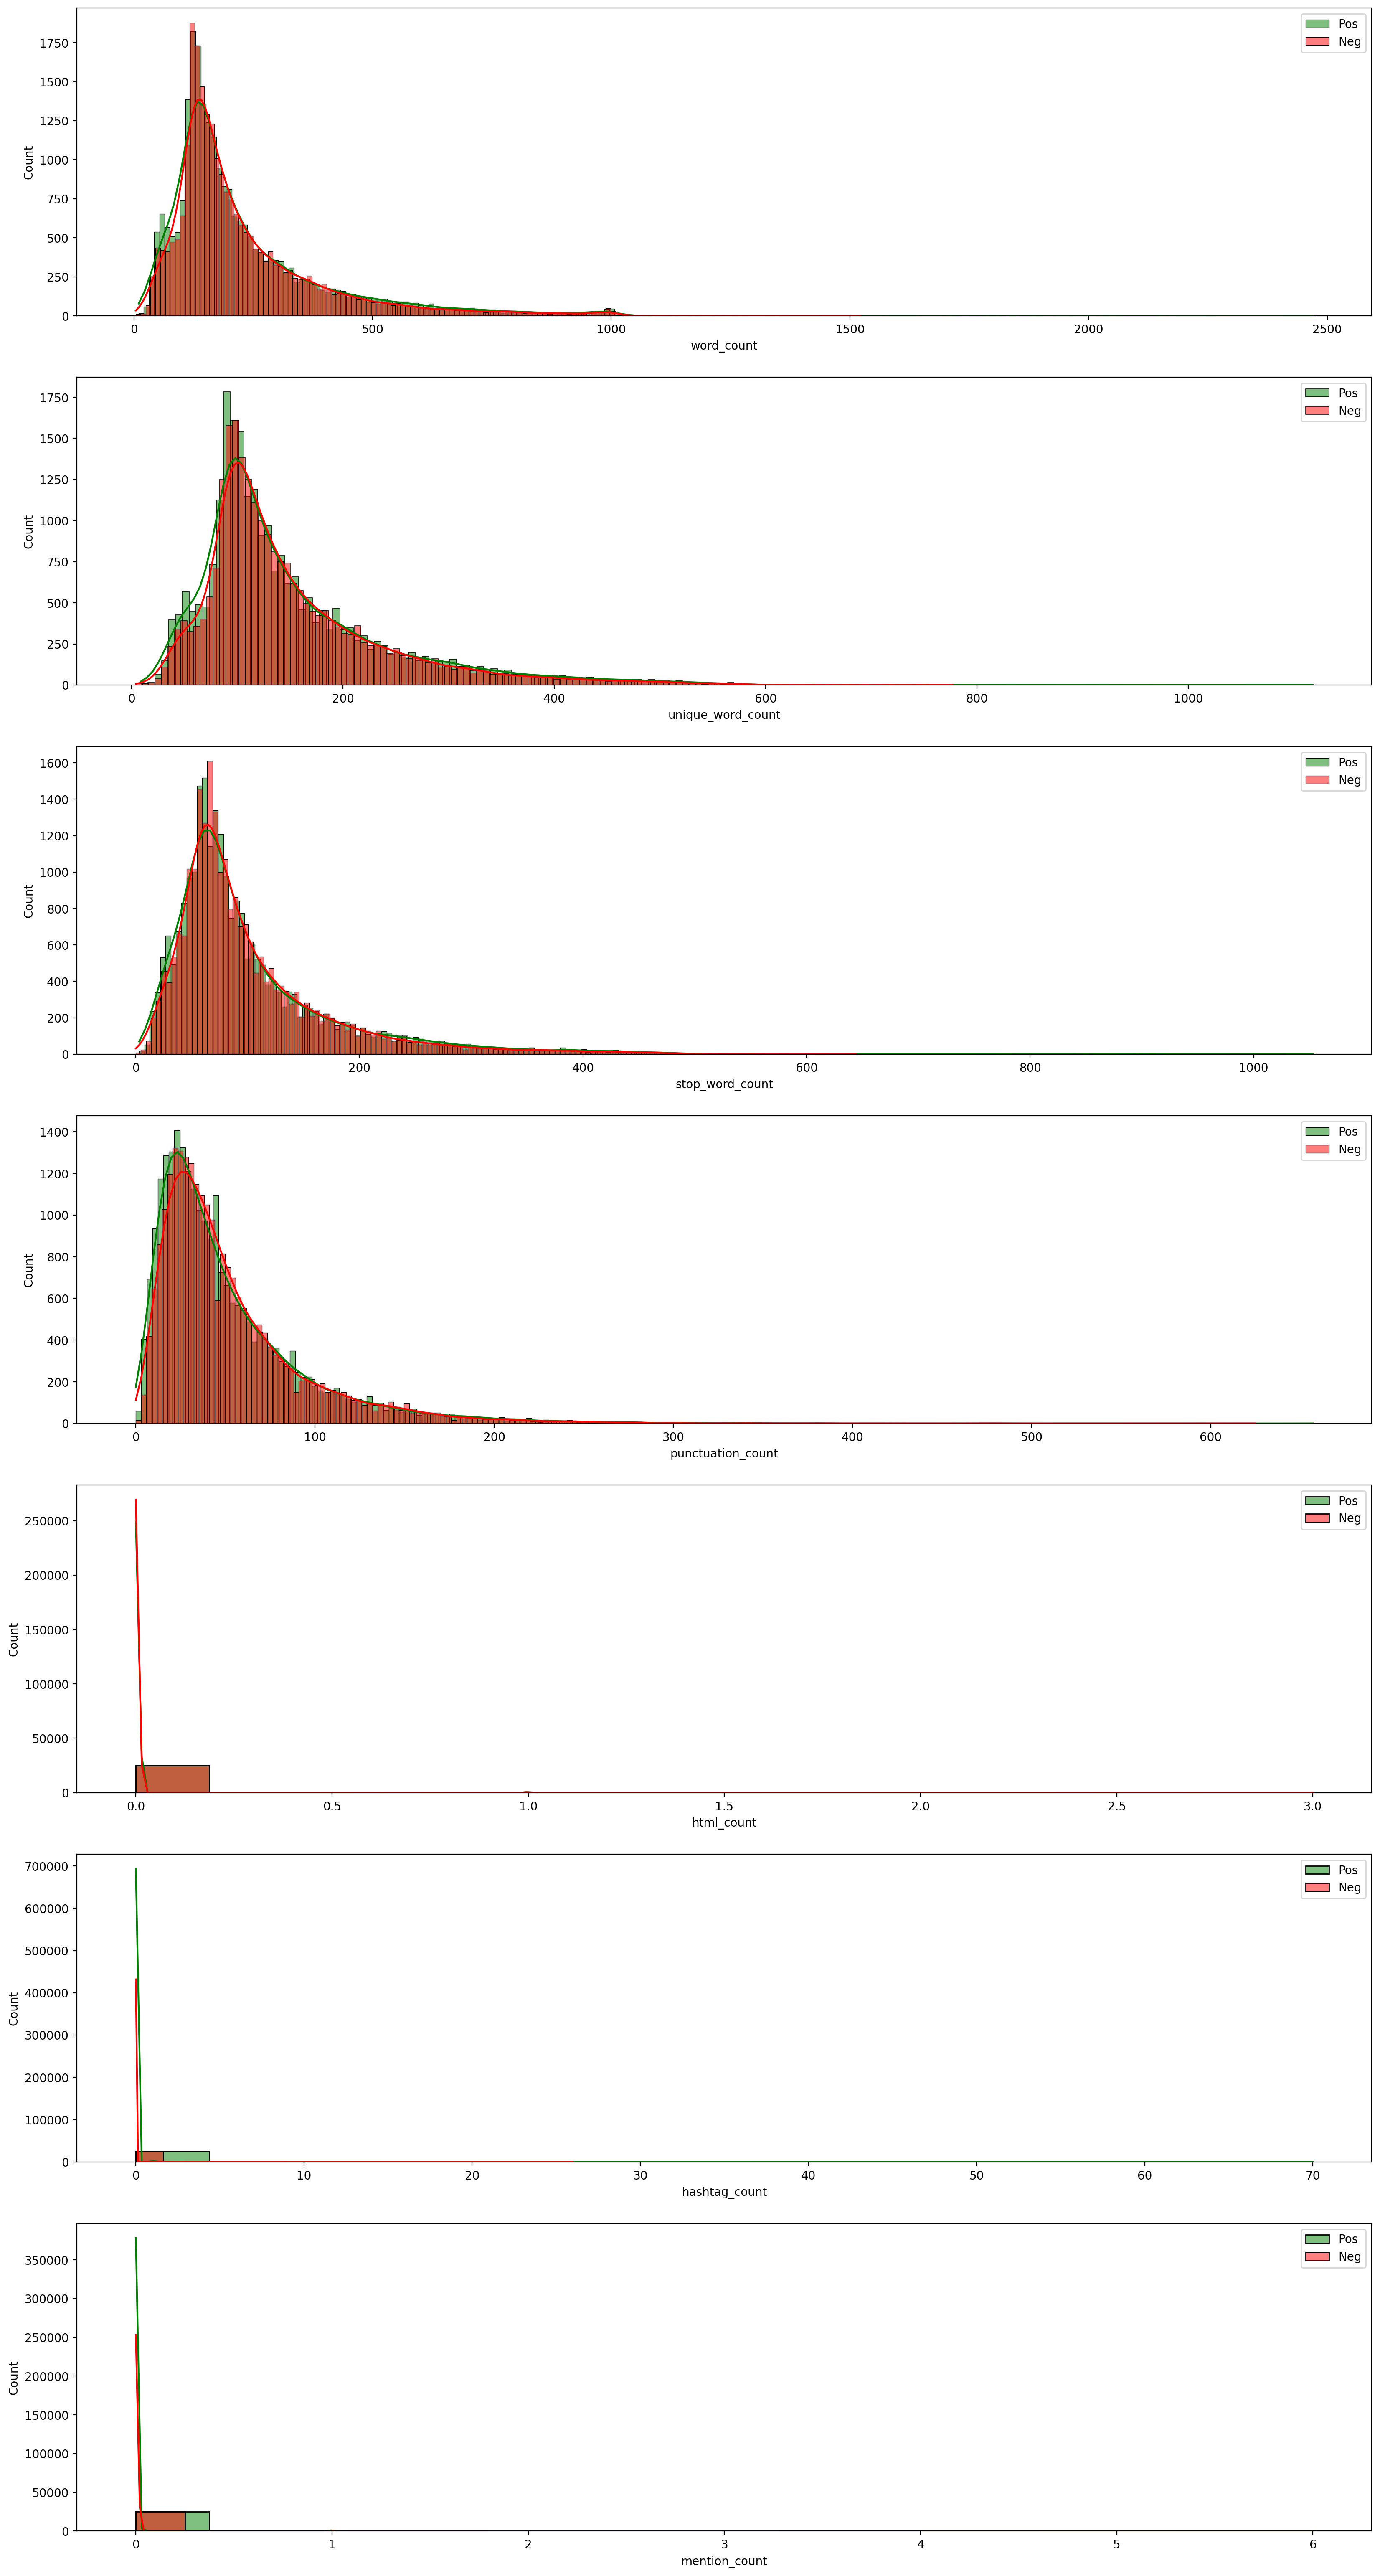

In [9]:
wordanalysis = ['word_count', 'unique_word_count', 'stop_word_count', 'punctuation_count', 'html_count', 'hashtag_count', 'mention_count']

fig, axes = plt.subplots(nrows=len(wordanalysis), figsize=(20, 40), dpi=100)

for i, feature in enumerate(wordanalysis):
    sns.histplot(df.loc[df.sentiment=='positive'][feature], label='Pos', ax=axes[i], color='green', kde=True)
    sns.histplot(df.loc[df.sentiment=='negative'][feature], label='Neg', ax=axes[i], color='red', kde=True)
    axes[i].legend()
    
plt.show()

### Tokenization and Normalization for Preparation

For preprocessing, we will apply the following steps:

1. contract the word 
2. Remove HTML tag (`<br />` in this case) from the review text
3. Remove punctuations (replace with whitespace)
4. Lowercase 
5. Split review text into tokens
6. Remove tokens that are considered as "**stopwords**"
7. For the rest, do stemming and/or lemmatization (Normalization)

In [10]:
lemmatizer = nltk.WordNetLemmatizer()

In [11]:
lemmatizer.lemmatize('driving', 'v')

'drive'

In [12]:
def fix_contractions(text):
    return contractions.fix(text)

df['review']=df['review'].apply(lambda x : fix_contractions(x))

In [13]:
def preprocessing(text):
    
    # Lower case
    text = text.lower().strip()
    
    #Replace HTML tag
    text = text.replace('<br />', '').strip()
    
    # Remove digit()
    text = re.sub(r'[0-9]*', '',text)
    
    #punctuation removal
    punc_translation = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(punc_translation)
    tokens = text.split()
    
    #stopwords
    tokens = [word for word in tokens if word not in stopwords]
    
    return ' '.join(tokens)

In [14]:
# we can use tf preprocessing tool as well if we don't want to remove stop words etc.
'''
def tf_preprocessing(text):
    # Lower case
    text = text.lower().strip()
    
    #Replace HTML tag
    text = text.replace('<br />', '').strip()
    
    return tf.keras.preprocessing.text.text_to_word_sequence(text)
'''

In [15]:
#Lemmatize the dataset

def lemma_traincorpus(text):
    lemmatizer = nltk.WordNetLemmatizer()
    out_data=""
    for words in text.split():
        out_data+= lemmatizer.lemmatize(words, 'v') + ' '
    return out_data

In [16]:
df['text_prep']=df['review'].apply(preprocessing)

df

,review,sentiment,word_count,unique_word_count,stop_word_count,punctuation_count,html_count,mention_count,hashtag_count,text_prep
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is cal...",positive,307,208,133,78,0,0,0,one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home many aryans muslims gangstas latinos christians italians...
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",positive,162,114,66,44,0,0,0,wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disa...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",positive,166,121,76,40,0,0,0,thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love would laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel...
3,"Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you are going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally...",negative,138,96,62,42,0,0,0,basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorci

In [17]:

df['text_prep']=df['text_prep'].apply(lambda x: lemma_traincorpus(x))

df

,review,sentiment,word_count,unique_word_count,stop_word_count,punctuation_count,html_count,mention_count,hashtag_count,text_prep
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is cal...",positive,307,208,133,78,0,0,0,one reviewers mention watch oz episode hook right exactly happen first thing strike oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cells glass front face inwards privacy high agenda city home many aryans muslims gangstas latinos christians italians irish scuffle death...
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",positive,162,114,66,44,0,0,0,wonderful little production film technique unassuming old time bbc fashion give comfort sometimes discomforting sense realism entire piece actors extremely well choose michael sheen get polari voice pat truly see seamless edit guide reference williams diary entries well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little things fantasy guard rather use traditional dream techniques remain solid disappear play knowledge s...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",positive,166,121,76,40,0,0,0,think wonderful way spend time hot summer weekend sit air condition theater watch light hearted comedy plot simplistic dialogue witty character likable even well bread suspect serial killer may disappoint realize match point risk addiction think proof woody allen still fully control style many us grow love would laugh one woody comedies years dare say decade never impress scarlet johanson manage tone sexy image jump right average spirit young woman may crown jewel career wittier devil wear p...
3,"Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you are going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally...",negative,138,96,62,42,0,0,0,basically family little boy jake think zombie closet parent fight time movie slower soap opera suddenly jake decide become rambo kill zombie ok first go make film must decide thriller drama drama movie watchable parent divorce argue lik

In [18]:
df['sentiment'] = df.sentiment.map({'positive':1, 'negative':0})

df

,review,sentiment,word_count,unique_word_count,stop_word_count,punctuation_count,html_count,mention_count,hashtag_count,text_prep
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is cal...",1,307,208,133,78,0,0,0,one reviewers mention watch oz episode hook right exactly happen first thing strike oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cells glass front face inwards privacy high agenda city home many aryans muslims gangstas latinos christians italians irish scuffle death...
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly wr...",1,162,114,66,44,0,0,0,wonderful little production film technique unassuming old time bbc fashion give comfort sometimes discomforting sense realism entire piece actors extremely well choose michael sheen get polari voice pat truly see seamless edit guide reference williams diary entries well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little things fantasy guard rather use traditional dream techniques remain solid disappear play knowledge s...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />T...",1,166,121,76,40,0,0,0,think wonderful way spend time hot summer weekend sit air condition theater watch light hearted comedy plot simplistic dialogue witty character likable even well bread suspect serial killer may disappoint realize match point risk addiction think proof woody allen still fully control style many us grow love would laugh one woody comedies years dare say decade never impress scarlet johanson manage tone sexy image jump right average spirit young woman may crown jewel career wittier devil wear p...
3,"Basically there is a family where a little boy (Jake) thinks there is a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you are going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally...",0,138,96,62,42,0,0,0,basically family little boy jake think zombie closet parent fight time movie slower soap opera suddenly jake decide become rambo kill zombie ok first go make film must decide thriller drama drama movie watchable parent divorce argue like real life jake closet tota

In [19]:
# unigram count
df['word_count_af'] = df['text_prep'].apply(lambda x: len(str(x).split()))

# unique word count
df['unique_word_count_af'] = df['text_prep'].apply(lambda x: len(set(str(x).split())))

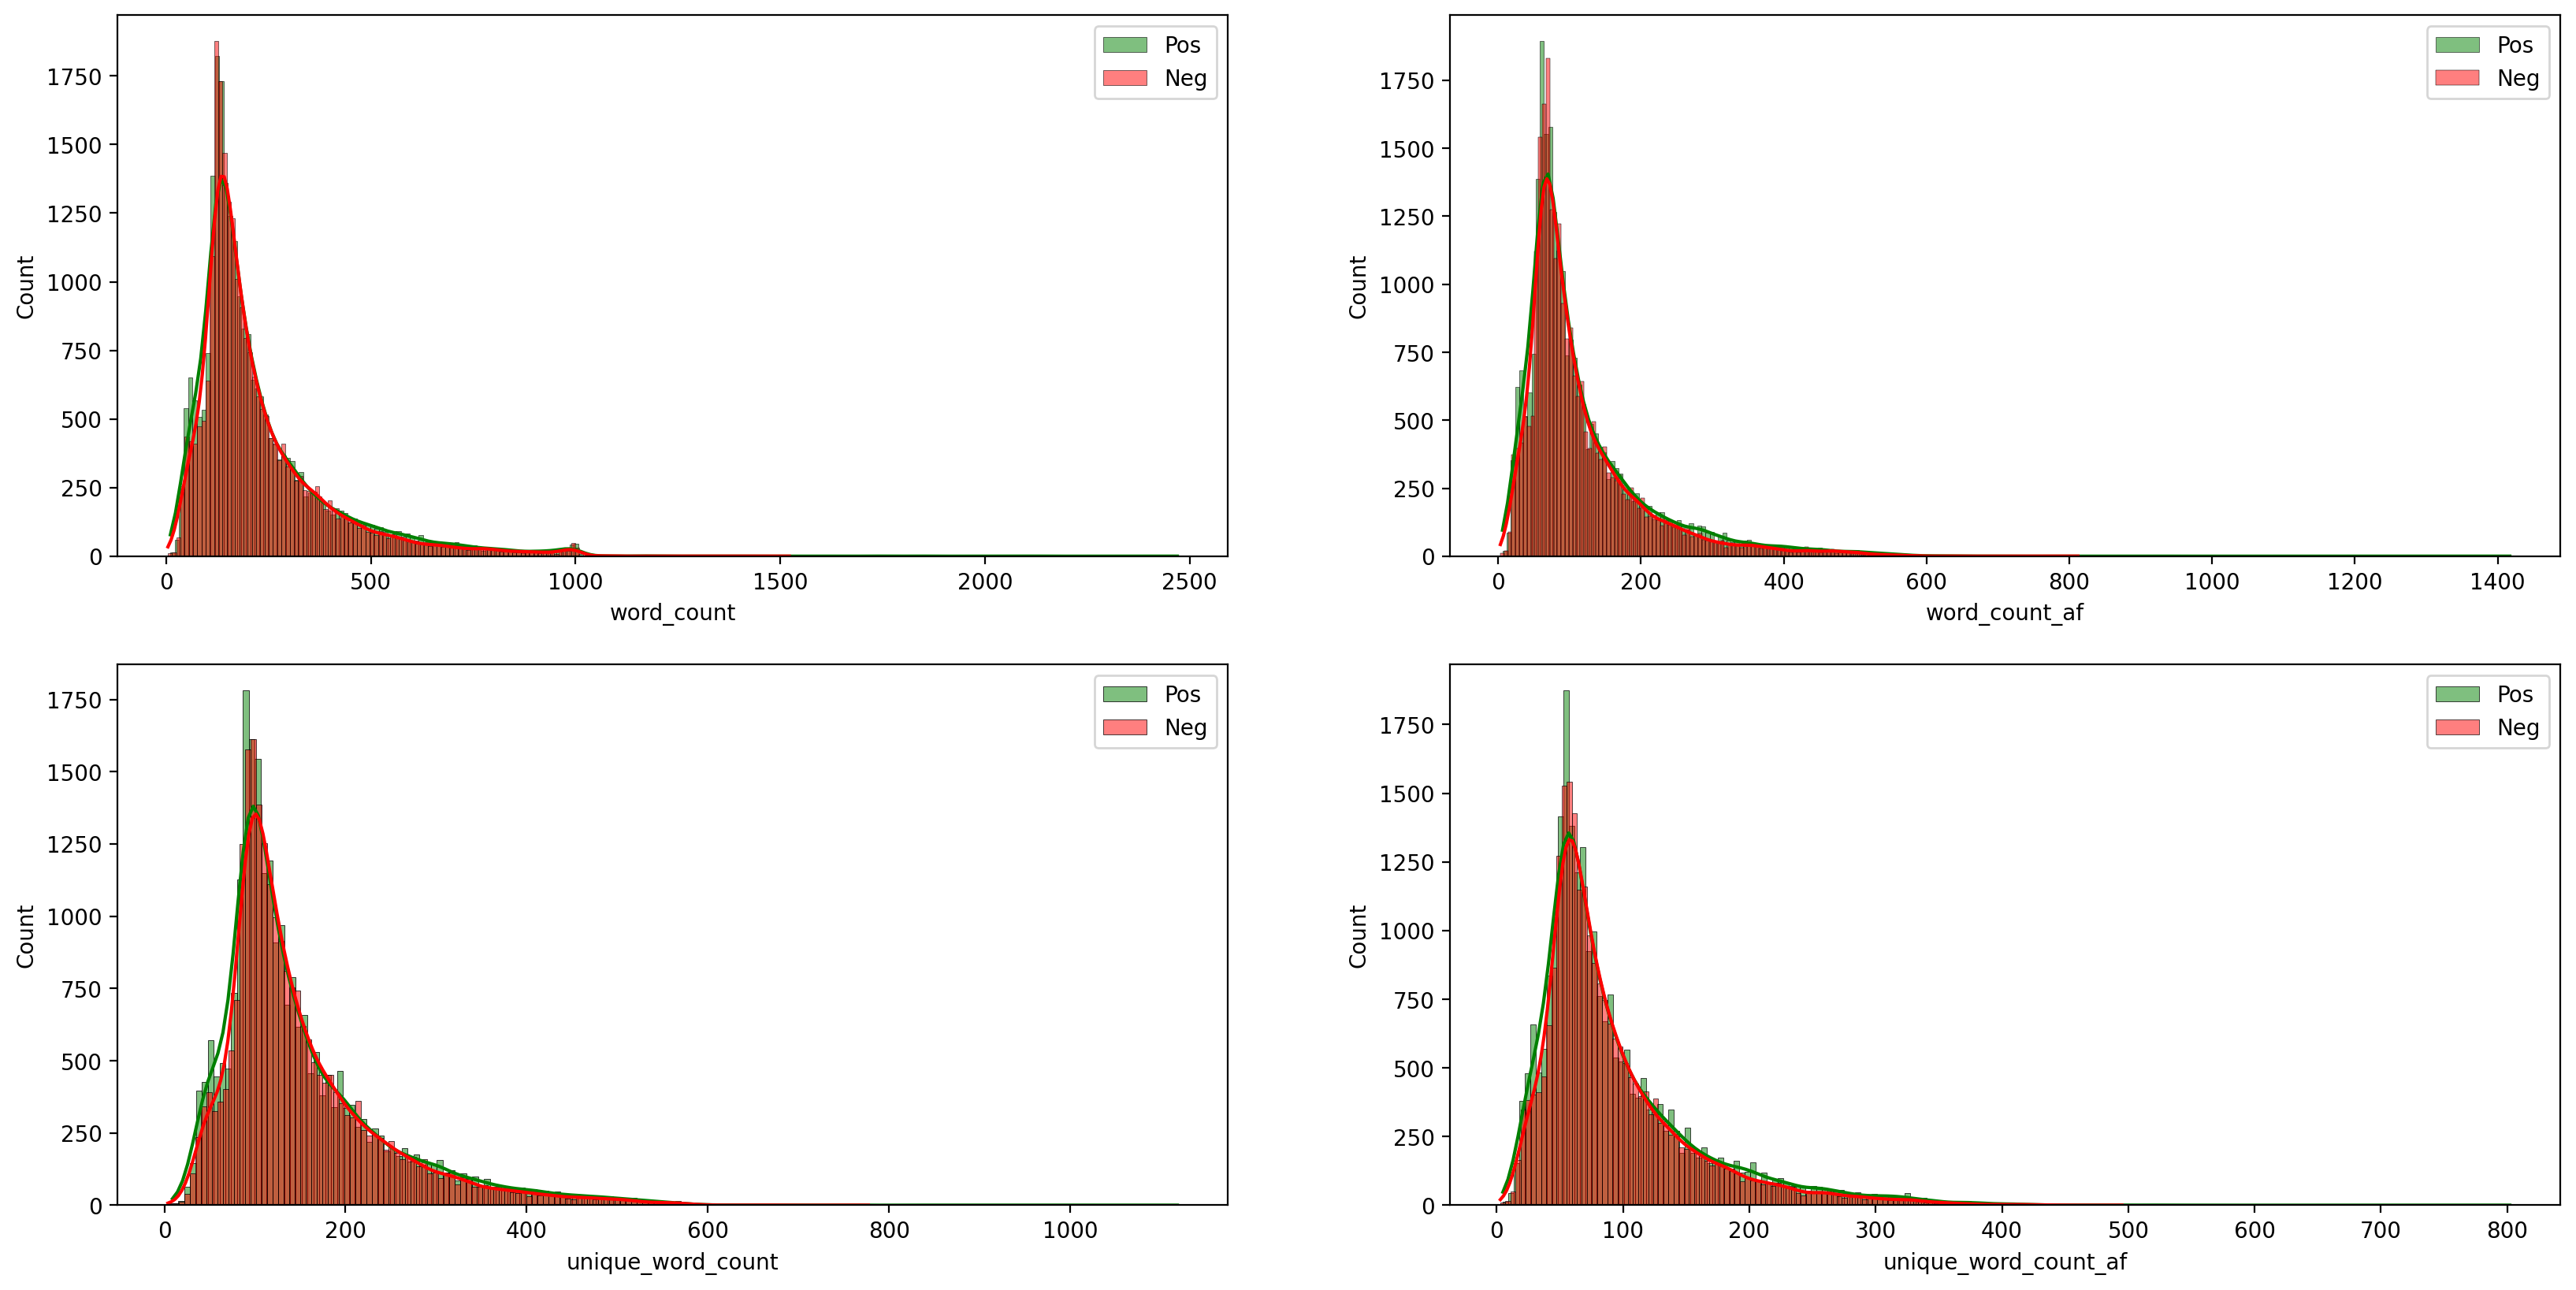

In [20]:
wordanalysis = ['word_count', 'unique_word_count']

fig, axes = plt.subplots(ncols = 2, nrows=len(wordanalysis), figsize=(20, 10), dpi=100)

for i, feature in enumerate(wordanalysis):
    sns.histplot(df.loc[df.sentiment==1][feature], label='Pos', ax=axes[i][0], color='green', kde=True)
    sns.histplot(df.loc[df.sentiment==0][feature], label='Neg', ax=axes[i][0], color='red', kde=True)
    
    sns.histplot(df.loc[df.sentiment==1][feature+'_af'], label='Pos', ax=axes[i][1], color='green', kde=True)
    sns.histplot(df.loc[df.sentiment==0][feature+'_af'], label='Neg', ax=axes[i][1], color='red', kde=True)
    
    for j in range(2):
        axes[i][j].legend()
    
plt.show()

### Split data

In [21]:
x = df['text_prep']
y = df['sentiment']

In [22]:
trainx, testx, trainy, testy = train_test_split(x,y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [23]:
trainy.value_counts()

0    20000
1    20000
Name: sentiment, dtype: int64

In [24]:
positive = df[df.sentiment == 1]['text_prep']

positive.shape

(25000,)

In [25]:
negative = df[df.sentiment == 0]['text_prep']

negative.shape

(25000,)

### Build Vocabulary

Instead of using `CountVectorizer` (N-gram) provided by sklearn directly, we will build the vocabulary on our own, so that we have more control over it.

<span style="color:red">**Tips:**</span>

We can only use words in training data for building vocabulary

In [26]:
all_tokens = [word for t in trainx for word in t.split()]

In [27]:
len(all_tokens)

4742247

In [28]:
voca = nltk.FreqDist(all_tokens)

In [29]:
# Get a vocab set with fixed size
vocab_size = 10000
topwords = [word for word, _ in voca.most_common(vocab_size)]
print(len(topwords))

10000


In [30]:
topwords[:20]

['film',
 'movie',
 'one',
 'make',
 'like',
 'see',
 'get',
 'time',
 'would',
 'good',
 'character',
 'go',
 'watch',
 'even',
 'think',
 'really',
 'story',
 'show',
 'well',
 'look']

In [31]:
_1gram = all_tokens
_2gram = [' '.join(e) for e in ngrams(_1gram,2)]

In [32]:
_2gram

['catch little',
 'little gem',
 'gem totally',
 'totally accident',
 'accident back',
 'back revival',
 'revival theatre',
 'theatre see',
 'see two',
 'two old',
 'old silly',
 'silly sci',
 'sci fi',
 'fi movies',
 'movies theatre',
 'theatre pack',
 'pack full',
 'full warn',
 'warn show',
 'show bunch',
 'bunch sci',
 'sci fi',
 'fi short',
 'short spoof',
 'spoof get',
 'get us',
 'us mood',
 'mood somewhat',
 'somewhat amuse',
 'amuse come',
 'come within',
 'within second',
 'second audience',
 'audience hysterics',
 'hysterics biggest',
 'biggest laugh',
 'laugh come',
 'come show',
 'show princess',
 'princess laia',
 'laia huge',
 'huge cinnamon',
 'cinnamon buns',
 'buns instead',
 'instead hair',
 'hair head',
 'head look',
 'look camera',
 'camera give',
 'give grim',
 'grim smile',
 'smile nod',
 'nod make',
 'make even',
 'even funnier',
 'funnier get',
 'get see',
 'see chewabacca',
 'chewabacca play',
 'play look',
 'look like',
 'like muppet',
 'muppet extremely',
 '

In [33]:
bigram_vocab = nltk.FreqDist(_2gram)

bigram_vocab.most_common()

[('look like', 3018),
 ('ever see', 2373),
 ('watch movie', 2350),
 ('see movie', 2081),
 ('film make', 1885),
 ('special effect', 1857),
 ('let us', 1715),
 ('even though', 1598),
 ('make movie', 1574),
 ('main character', 1569),
 ('one best', 1554),
 ('see film', 1497),
 ('make film', 1494),
 ('low budget', 1485),
 ('movie make', 1454),
 ('waste time', 1416),
 ('watch film', 1327),
 ('year old', 1288),
 ('want see', 1256),
 ('much better', 1207),
 ('horror film', 1184),
 ('seem like', 1161),
 ('good movie', 1160),
 ('first time', 1144),
 ('take place', 1138),
 ('film like', 1115),
 ('sci fi', 1099),
 ('would like', 1058),
 ('new york', 1046),
 ('make sense', 1024),
 ('years ago', 1020),
 ('movie ever', 1007),
 ('bad guy', 1000),
 ('real life', 976),
 ('film ever', 953),
 ('ever make', 948),
 ('high school', 941),
 ('feel like', 929),
 ('movie would', 922),
 ('film one', 902),
 ('like movie', 893),
 ('pretty much', 892),
 ('pretty good', 881),
 ('go see', 878),
 ('movie like', 857),
 

In [34]:
all_pos = ' '.join([word for t in positive for word in t.split() if word in topwords[100:500]])

#all_pos

In [35]:
all_neg = ' '.join([word for t in negative for word in t.split() if word in topwords[100:500]])

#all_neg

<function matplotlib.pyplot.show(close=None, block=None)>

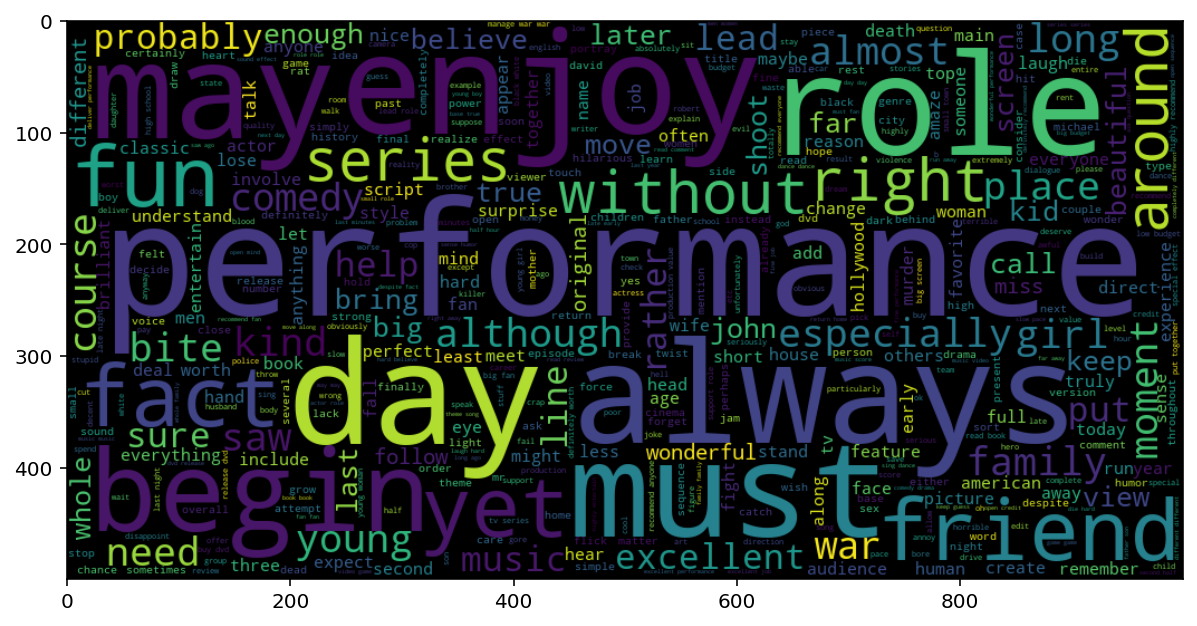

In [36]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(all_pos)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

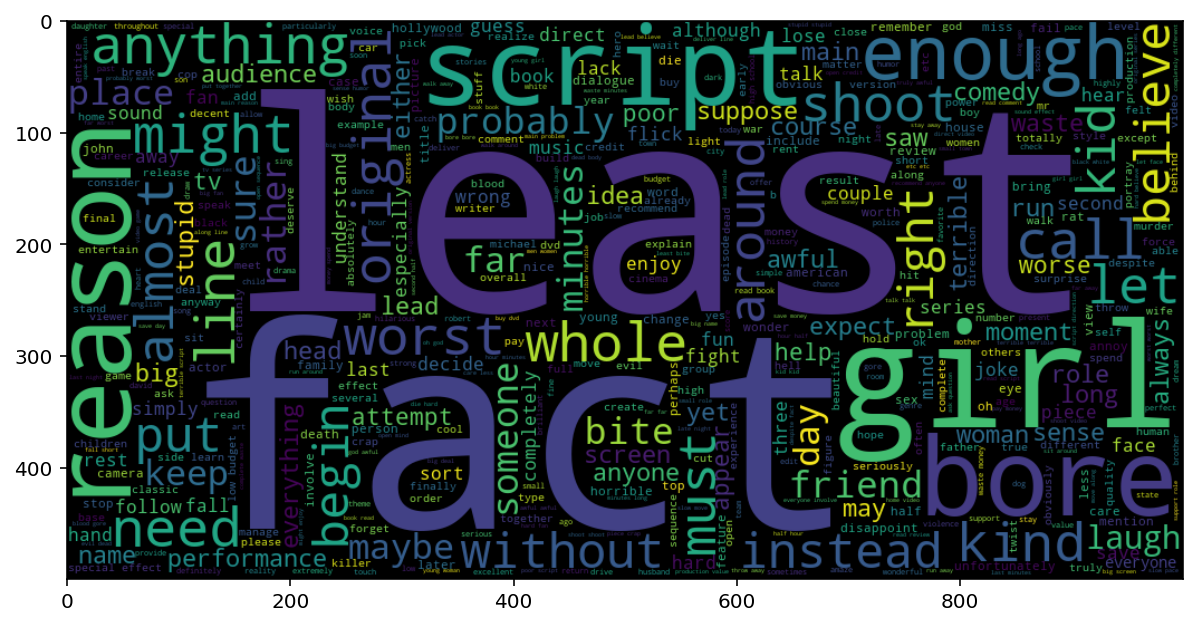

In [37]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(all_neg)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### Vectorizer

For this section, we will try two ways to do vectorization: **BoW** (1-gram) and **BoW with Tfidf Transformer**.

### Tf–idf Transformer

- Tf: Term-Frequency
- idf: Inverse Document-Frequency
- Tf-idf = $tf(t,d) \times idf(t)$

$$
idf(t) = log{\frac{1 + n_d}{1 + df(d, t)}} + 1
$$

![](http://www.onemathematicalcat.org/Math/Algebra_II_obj/Graphics/log_base_gt1.gif)

** We can test BoW to vecterize the data as well. Next example just show the TfIdf result. <br>
** We can test unigram, bigram, trigrams as well. Next, it only demostrates the unigram result.

In [38]:
# Use topwords as vocabulary

tf_vec = TfidfVectorizer(vocabulary=topwords) #ngram_range=(1,3)) 

train_features = tf_vec.fit_transform(trainx)

test_features = tf_vec.transform(testx)

In [39]:
print(train_features.shape)
print(test_features.shape)

(40000, 10000)
(10000, 10000)


In [40]:
# BoW
# CountVectorizer()

In [41]:
train_features[0][:100].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

## Training

### [Multinomial NB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

The multinomial Naive Bayes classifier is suitable for **classification with discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [42]:
mnb_model = MultinomialNB()
mnb_model

MultinomialNB()

In [43]:
%%time

# Train Model
mnb_model.fit(train_features, trainy)

Wall time: 19.3 ms


MultinomialNB()

In [44]:
# training Logistic model
lr = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
lr_tfidf=lr.fit(train_features,trainy)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)


## Evaluation

In [45]:
# Predict on test set
pred = mnb_model.predict(test_features)
print(pred)

[1 1 1 ... 0 1 1]


In [46]:
print('Accuracy: %f' % metrics.accuracy_score(pred,testy))

Accuracy: 0.857200


In [47]:
pred2 = lr.predict(test_features)

In [48]:
print('Accuracy: %f' % metrics.accuracy_score(pred2,testy))

Accuracy: 0.895400


In [49]:
# Pass in as keyword arguments to make sure the order is correct
print(
    metrics.classification_report(y_true=testy, y_pred=pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5000
           1       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [50]:
# Pass in as keyword arguments to make sure the order is correct
print(
    metrics.classification_report(y_true=testy, y_pred=pred2))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Predict new text

In [51]:
def predict_new(prep_func,  # func for preprocessing
                vec,        # vectorizer
                model,      # model
                text):      # text
    
    prep_text = prep_func(text)
    features = vec.transform([prep_text])
    pred = model.predict(features)
    return pred[0]

In [52]:
from functools import partial

predict_new_p1 = partial(predict_new, preprocessing, tf_vec, mnb_model)

In [53]:
predict_new_p1('it\'s not too bad')

0

In [54]:
predict_new_p1('it\'s nice')

1

## Tunning hyper parameters

In [55]:
def train_with_n_topwords(n: int, tfidf=False) -> tuple:
    
    topwords = [word for word, _ in voca.most_common(n)]
    
    if tfidf:
        vec = TfidfVectorizer(vocabulary=topwords)
    else:
        vec = CountVectorizer(vocabulary=topwords)
    
    # Generate feature vectors
    train_features = vec.fit_transform(trainx)
    test_features  = vec.transform(testx)
    
    # NB
    mnb_model = MultinomialNB()
    mnb_model.fit(train_features, trainy)
    
    # Test predict
    pred = mnb_model.predict(test_features)
    
    return metrics.accuracy_score(pred, testy), mnb_model, vec

In [56]:
train_with_n_topwords(500, tfidf=True)

(0.8284,
 MultinomialNB(),
 TfidfVectorizer(vocabulary=['film', 'movie', 'one', 'make', 'like', 'see',
                             'get', 'time', 'would', 'good', 'character', 'go',
                             'watch', 'even', 'think', 'really', 'story', 'show',
                             'well', 'look', 'say', 'know', 'much', 'end', 'bad',
                             'could', 'people', 'also', 'great', 'first', ...]))

In [57]:
possible_n = [500 * i for i in range(1, 20)]

cnt_accuracies = []
tfidf_accuracies = []

for n in tqdm(possible_n):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])

  0%|          | 0/19 [00:00<?, ?it/s]

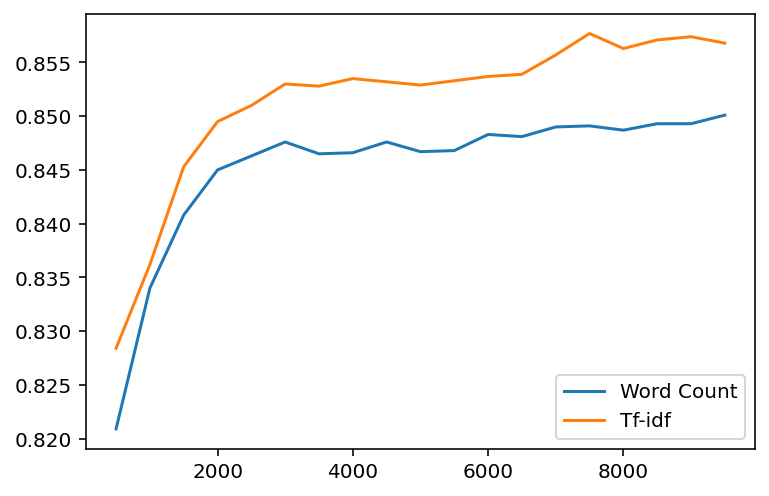

In [58]:
plt.plot(possible_n, cnt_accuracies, label='Word Count')
plt.plot(possible_n, tfidf_accuracies, label='Tf-idf')
plt.legend()
plt.show()

** Model turns to be stable after top words >= 3500

## Save model

In [63]:
_, model, vec = train_with_n_topwords(4000, tfidf=True)

In [64]:
import pickle

with open('tf_vec.pkl', 'wb') as fp:
    pickle.dump(vec, fp)
    
with open('mnb_model.pkl', 'wb') as fp:
    pickle.dump(model, fp)

### Word Embedding
word embedding is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words etc. <br>
if we use one-hot-encoding to represent each word, the similar word 'good' and 'great' are as different as 'flower' (or any other words), which is not true. <br>

The objection of word embedding is to have words with similar context occupy close spatial positions. Mathematically, the cosine of the angle between 'good' and 'great' should be close to 1, on the other hand, the cosine of the angle between 'good' and 'flower' should be close to 0. 

In [101]:
embedding_dict={}
with open('./glove/glove.6B.200d.txt','r', encoding="utf-8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [102]:
def create_corpus(df):
    corpus=[]
    for w in tqdm(df['text_prep']):
        words=[word.lower() for word in word_tokenize(w) if((word.isalpha()==1) & (word not in stopwords))]
        corpus.append(words)
    return corpus

corpus=create_corpus(df)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [103]:
MAX_LEN=300
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

text_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [104]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 88639


In [105]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,200))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

  0%|          | 0/88639 [00:00<?, ?it/s]

In [106]:
model=Sequential()

embedding=Embedding(num_words,200,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_length=MAX_LEN,trainable=False)

model.add(embedding)
#model.add(Embedding(num_words,200,embeddings_initializer=Constant(embedding_matrix),
                   #input_length=MAX_LEN,trainable=False))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 200)          17728000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,795,905
Trainable params: 67,905
Non-trainable params: 17,728,000
_________________________________________________________________


In [107]:
train=text_pad[:36000]
test=text_pad[36000:]

In [111]:
train.shape

(36000, 300)

In [112]:
test.shape

(14000, 300)

In [114]:
x_train,x_val,y_train,y_val=train_test_split(train,df['sentiment'][:36000].values,test_size=0.25)
print('Shape of train',x_train.shape)
print("Shape of Validation ",x_val.shape)

Shape of train (27000, 300)
Shape of Validation  (9000, 300)


In [118]:
history=model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_val,y_val),verbose=2)

Epoch 1/10
844/844 - 564s - loss: 0.6887 - accuracy: 0.5170 - val_loss: 0.6869 - val_accuracy: 0.5240
Epoch 2/10
844/844 - 552s - loss: 0.6874 - accuracy: 0.5224 - val_loss: 0.6835 - val_accuracy: 0.5503
Epoch 3/10
844/844 - 540s - loss: 0.6511 - accuracy: 0.6360 - val_loss: 0.6306 - val_accuracy: 0.7053
Epoch 4/10
844/844 - 567s - loss: 0.6264 - accuracy: 0.6781 - val_loss: 0.6090 - val_accuracy: 0.7180
Epoch 5/10
844/844 - 747s - loss: 0.6133 - accuracy: 0.6895 - val_loss: 0.6146 - val_accuracy: 0.7194
Epoch 6/10
844/844 - 647s - loss: 0.6057 - accuracy: 0.6979 - val_loss: 0.5875 - val_accuracy: 0.7243
Epoch 7/10
844/844 - 650s - loss: 0.6033 - accuracy: 0.7009 - val_loss: 0.5856 - val_accuracy: 0.7328
Epoch 8/10
844/844 - 669s - loss: 0.5967 - accuracy: 0.7117 - val_loss: 0.5951 - val_accuracy: 0.7249
Epoch 9/10
844/844 - 696s - loss: 0.5902 - accuracy: 0.7157 - val_loss: 0.5679 - val_accuracy: 0.7432
Epoch 10/10
844/844 - 641s - loss: 0.5877 - accuracy: 0.7185 - val_loss: 0.5637 - 

In [120]:
yhat = model.predict(test)
yhat.shape

(14000, 1)

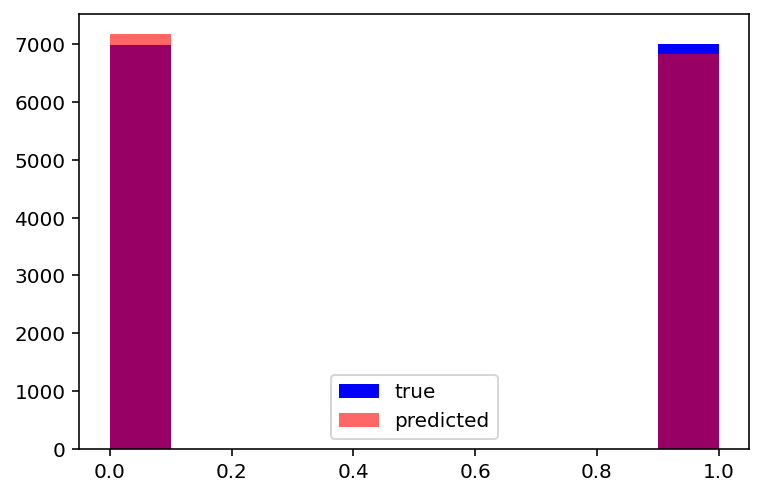

In [125]:
plt.hist(df['sentiment'][36000:], color='blue')
plt.hist(np.round(yhat), color='red', alpha=0.6)
plt.legend(['true', 'predicted'])
plt.show()

In [126]:
# Pass in as keyword arguments to make sure the order is correct
print(
    metrics.classification_report(y_true=df['sentiment'][36000:], y_pred=np.round(yhat)))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      6991
           1       0.75      0.73      0.74      7009

    accuracy                           0.75     14000
   macro avg       0.75      0.75      0.75     14000
weighted avg       0.75      0.75      0.75     14000



**We can test more iterations of model fitting with word embedding method. I stopped at 10 iterations since the computation power is low.**

### Transfer learning - BERT

The limitation of Word Embedding is that they don’t take into consideration the order of words in which they appear which leads to loss of syntactic and semantic understanding of the sentence. <br>

BERT is a sentence embedding. it considers the order of words, also the relation between the words. 

** We should reprepare the input processing by not removing the stop words since BERT can read the context meaning between words. <br>
Due to the limitation of computation power of desktop, I just demo the flow with previous prep input

In [160]:
trainx2,valx,testx2 = df['text_prep'][:30000],df['text_prep'][30000:40000],df['text_prep'][40000:]
trainy2,valy,testy2 = df['sentiment'][:30000],df['sentiment'][30000:40000],df['sentiment'][40000:]

In [161]:
print(trainx2.shape)
print(valx.shape)
print(testx2.shape)

(30000,)
(10000,)
(10000,)


In [162]:
trainy2.value_counts()

1    15015
0    14985
Name: sentiment, dtype: int64

In [163]:
valy.value_counts()

0    5022
1    4978
Name: sentiment, dtype: int64

In [164]:
testy2.value_counts()

1    5007
0    4993
Name: sentiment, dtype: int64

In [183]:
# hyperparameters
max_length = 500 # max length of review 
batch_size = 128 # batch size

In [184]:
# Bert Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [185]:
def bert_encode(data):
    input_ids = []
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, pad_to_max_length=True, truncation=True)
    #padding='max_length', 
    #print(tokens[0])
    
    print(len(tokens['input_ids']))
    
    return tf.constant(tokens['input_ids'], shape=np.array(tokens['input_ids']).shape)

In [186]:
train_encoded = bert_encode(trainx2)
dev_encoded = bert_encode(valx)

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, trainy2))
    #.shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, valy))
    #.shuffle(128)
    .batch(batch_size)
)

30000
10000


In [187]:
def bert_model():

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
    x = tf.keras.layers.Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(input_word_ids, outputs)
    
    model.layers[1].trainable = False

    return model

In [188]:
#with strategy.scope():
model = bert_model()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 500)]             0         
_________________________________________________________________
tf_bert_model_3 (TFBertModel ((None, 500, 768), (None, 109482240 
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 500, 768)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 498, 32)           73760     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 109,662,601
Trainable params: 180,361
Non-trainable params: 109,482,240
__________________________________

In [189]:
#tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [190]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5)]

In [191]:
# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=dev_dataset
)
    #verbose=1,
    #callbacks = callbacks)

Epoch 1/3
235/235 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.6356  

KeyboardInterrupt: 

**Killed** after one iteration. It takes too long on my own computer. 